In [182]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [183]:
with open("data/names.txt","r") as f:
    words = f.read().lower().split('\n')
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [184]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [185]:
chars = sorted(list(set(''.join(words))))
str_to_idx = {c:i+1 for i,c in enumerate(chars)}
str_to_idx['.'] = 0
idx_to_str = {i:c for c,i in str_to_idx.items()}

In [186]:
block_size = 10
embed_sz = 5
vocab_size = len(str_to_idx)

In [187]:
def build_dateset(words):
    X, Y = [],[]
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = str_to_idx[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    return torch.tensor(X).to(device),torch.tensor(Y).to(device)

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dateset(words[:n1])
Xdev,Ydev = build_dateset(words[n1:n2])
Xte,Yte = build_dateset(words[n2:])

In [188]:
def conv1d_dim_out(input_len, kernel_sz, padding = 0, dilation = 1, stride = 1):
    from math import floor
    return  floor((input_len+2*padding-dilation*(kernel_sz - 1) - 1)//stride) + 1
h = 8
h = conv1d_dim_out(h,3)
h = conv1d_dim_out(h,3,dilation=2,padding=2)
h = conv1d_dim_out(h,3,dilation=4,padding=4)
h = conv1d_dim_out(h,3,dilation=8,padding=8)
h

6

# DILATION


In [189]:
class Wavenet_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size,embed_sz),
        )
        self.dilation = nn.Sequential(
            nn.Conv1d(1,1,5,dilation=1),
            nn.Conv1d(1,1,3,dilation=2,padding=2),
            nn.Conv1d(1,1,3,dilation=4,padding=4),
            nn.Conv1d(1,1,3,dilation=8,padding=8),
        )
        conv_out_dim = 46
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_out_dim,150,bias=False),
            nn.BatchNorm1d(150),
            nn.Tanh(),
            nn.Dropout(0.1),
            
            nn.Linear(150,vocab_size),
            nn.LogSoftmax(1),
        )
    def forward(self, x):
        x = self.embed(x)
        x = self.dilation(x.view(x.size(0),1,-1))
        x = self.main(x)
        return x
model = Wavenet_Model().to(device)
tmp = Xtr[4:10]
print(tmp.shape)
out = model(tmp)
print(out.shape)

torch.Size([6, 10])
torch.Size([6, 27])


In [190]:
# optimization configurations
loss_fn = nn.CrossEntropyLoss()
epochs = 1000
max_learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,max_learning_rate,epochs)

In [191]:
train_lossi = []
test_lossi = []

In [192]:
for i in range(epochs):
    # forward pass
    pred = model(Xtr)
    loss = loss_fn(pred,Ytr)
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    # scheduler.step(loss)
    
    # tracing
    train_lossi.append(loss.item())
    with torch.no_grad():
        pred = model(Xte)
        loss = loss_fn(pred,Yte)
        test_lossi.append(loss.item())
    if i % 100 == 0:
        print(i,loss.item())
# 2.1701

0 3.1729297637939453
100 2.282355785369873
200 2.2257251739501953
300 2.1733291149139404
400 2.171438217163086
500 2.147526502609253
600 2.1417949199676514
700 2.141127824783325
800 2.1381750106811523
900 2.1414012908935547


In [200]:
model

Wavenet_Model(
  (embed): Sequential(
    (0): Embedding(27, 5)
  )
  (dilation): Sequential(
    (0): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (2): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (3): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
  )
  (main): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=46, out_features=150, bias=False)
    (2): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Tanh()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=150, out_features=27, bias=True)
    (6): LogSoftmax(dim=1)
  )
)

In [210]:
with torch.no_grad():
    pred = model(Xte)
    loss = loss_fn(pred,Yte)
    print(loss.item())

2.083874225616455


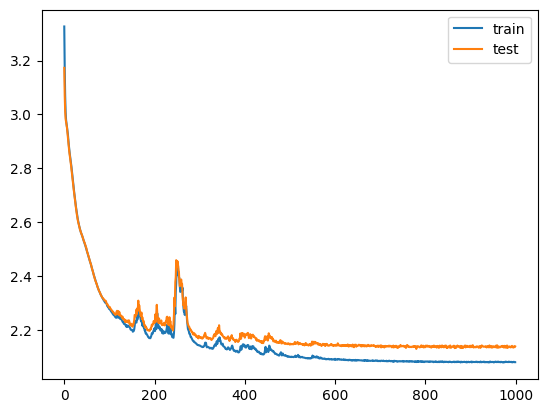

In [202]:
plt.plot(train_lossi[::],label='train')
plt.plot(test_lossi[::],label='test')
plt.legend()

In [208]:
model.eval() # change behaviour of batchnorm
g = torch.Generator(device).manual_seed(42*11)
for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor(context).to(device).view(1,-1))
        ix = torch.multinomial(logits.exp(),num_samples=1,generator=g).item()
        context = context[1:] +[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(idx_to_str[i] for i in out))

haedra.
aniso.
prideet.
evonenna.
saelon.
